# Setup


In [2]:
# If the below code doesn't work uncomment this and run (this adds the parent directory to the path)
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np
from numpy.random import dirichlet as diri

dl = DataLib("SignalData")

In [3]:
# Pull all the necessary dataframes to avoid duplicate code. 
BondRetIdx = dl.pull("BondRetIdx/LocalFX")
LongRates = dl.pull("LongRates")
ShortRates = dl.pull("ShortRates")
EquityPrices = dl.pull("EquityPrices")
M1 = dl.pull("M1/inUSD")
M2 = dl.pull("M2/inUSD")
M3 = dl.pull("M3/inUSD")
CurrAcctNom = dl.pull("CurrAcctNom/inUSD")
CurrAcctPctGDP = dl.pull("CurrAcctPctGDP")
nGDP = dl.pull("GDP/Nominal")
rGDP = dl.pull("GDP/Real")
nFxTrdWts = dl.pull("fxTrdWts/Nominal")
rFxTrdWts = dl.pull("fxTrdWts/Real")
fxVsUSD = dl.pull("fxVsUSD")
CoreCPI = dl.pull("CoreCPI/SA")

In [4]:
# Constants. 
WORKDAYS_IN_MONTH=21
WORKDAYS_IN_YEAR=261
QUARTERS_IN_YEAR=4
COUNTRIES=[
    'USA', 'AUS', 'JPN', 'CAN', 'CHE', 'GBR', 'ESP', 'FRA', 'ITA', 'DEU'
]

# Conventions

For the sake of sanity, I'm going to outline a few conventions here. 
- Variables which are directly from the datalib should begin with capital letters (e.g. `ShortRates`). 
    - Others variables should be lowercase with underscore separation. 
    - Derived variables (from datalib) can have capitals, but should be suffixed with underscore notation. 
- datalib variables should never be loaded again. They are loaded above. 
- Returns should always be graphed in red. No other indicator should ever be graphed in red. 

# Helper Functions

In [20]:
# TODO: get this working
def normalize_window(df, window): 
    sma = df.rolling(window).mean()
    df = df.subtract(sma, axis=0).divide(sma.std(axis=1), axis=0)
    return df

# Intro

What indicators should we choose? Why?
- FX Appreciation
- Monetary Base (captures something orthogonal to movements in FX) 
- GDP (are there any other data that we can supplement this with?)

Which shouldn't we choose? Why? 
- Change in GDP: as the prospectus outlines, changes in GDP are revised regularly. Additionally, GDP statistics are released with a lag, so wouldn't be practical for a real investment system. 
- Relative Stock/Bond Performance: this indicator seems to have an unsatisfying and hand-wavy explanation for how it affects bond returns. 
- Monetary Base: since monetary base in only useful if we assume an increase in monetary base is indicative of expansionary policy. This is not the case right now amidst the COVID-19 pandemic, however. (Is this a good enough reason to discount it?)

How are the indicators we have chosen related? Or are they unrelated? 
- The exchange rate is a function of inflow/outflow of money, which is related to economic growth, interest rates, and monetary base. So yes, all three are related. 

it may be interesting to consider not only each indicator in isolation, but how they may or may not complement one another -- what potential synergies might they have? redundancies?

# GDP
`TODO`: 
1. provide an overview of why we are using this indicator
2. (decide what data could supplement GDP)
3. (decide what data feeds we are going to need)
4. (find these on eikon)
5. (how should we manipulate the data)
6. (get some dataframes from datalib and Eikon)
7. generate an indicator
    - Should we use MA of change, or MA of the indicator, and get the pct_change of this? 

**1 - overview**

Questions that are relevant here: why do we use GDP for bond price prediction? What even is GDP? How is it measured? Are there any problems with how it is measured? Do we want to look at absolute GDP, or change, and why? 
- GDP: Gross domestic product. The sum of transactions within an economy. A proxy for the busyness of an economy. 
- It is measured in dollars. Some GDP measures take a while to be released, and hence may be somewhat impractical for a real investment system. 
- Absolute GDP is pretty nonsensical when we're trying to predict soveign bonds. The US having 100x more GDP than New Zealand tells us nothing about the price movements of bonds in those respective countries. Change is a more useful measure than magnitude for this reason. 

**2 - what other data could supplement GDP?**
- GDP itself
- unemployment
- HDI

**7 - generating an indicator**

Questions to be addressed:
- What relationship exists between GDP and returns? 
- What conceptual relationship exists between GDP and returns? Does this conflict with what we actually see?
- What relationship exists between GDP & yield?
- How should we apply smoothing? 

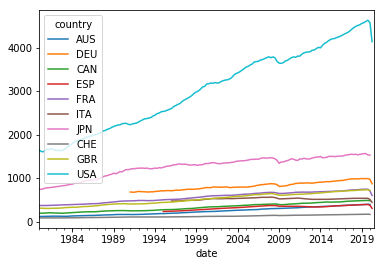

In [6]:
rGDP = dl.pull('GDP/real')
rGDP.plot()

In [7]:
# Get change; get mean of change; subtract this mean. 
rGDP_chg = rGDP.pct_change()
rGDP_chg_ave = rGDP_chg.mean(axis=1) # Mean for every time slice. 
rGDP_chg_centered = rGDP_chg.subtract(rGDP_chg_ave, axis=0)
rGDP_chg_z = rGDP_chg_centered.divide(rGDP_chg.std(axis=1), axis=0)

In [18]:
# Obtain the signal (percetiles from -1 to 1, for fully short to fully long)
signal = rGDP_chg_z.divide(rGDP_chg_z.abs().sum(axis=1), axis=0)

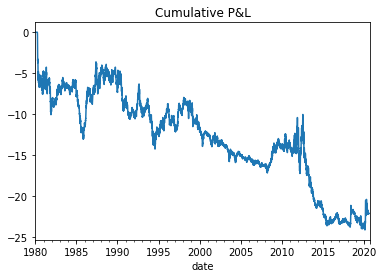

In [19]:
''' 
Evaluate (plot) the cumulative returns from a given signal. 
Assume the index of the signal is daily. 

We want these charts:
- bond returns
- our profit and loss
'''
def evaluate_returns(signal):

    # Multiply the signal for a given day by the next day's returns. 
    BondRetIdx_chg = BondRetIdx.pct_change()
    BondRetIdx_chg_shifted = BondRetIdx_chg.shift(-1)
    pnl = BondRetIdx_chg_shifted * signal
    pnl = pnl.sum(axis=1)
    
    # Get the cumulative p&l and plot in percentage terms. 
    cumul_pnl = (1+pnl).cumprod()
    cumul_pnl = (cumul_pnl-1)*100
    cumul_pnl.plot(title="Cumulative P&L")

signal = signal.resample('B').ffill()
evaluate_returns(signal)

# Monetary Base

`TODO`: 
1. provide an overview of why we are using this indicator
2. (decide what data could supplement GDP)
3. (decide what data feeds we are going to need)
4. (find these on eikon)
5. (how should we manipulate the data)
6. (get some dataframes from datalib and Eikon)
7. generate an indicator

**1 - overview of this indicator**
- money supply as a proxy for economic growth does not resonate --> in fact it might indicate the opposite of growth. Because of this, money supply might be a good complement to GDP (we might expect them to have negative correlations). Actually - does this make monetary base redundant? 
- often money supply grows at its fasted when the central bank is trying to stimulate a weak economy. Japan has been pumping money into the system for decades for little to no effect, either in terms of spuring growth or generating their desired level of inflation. Japan's a good case study for how money supply growth spurring inflation may break down. 

**7 - generate an indicator**

This is a little problematic because not all countries have M1/M2/M3. We need a way to have a standardized measure of money supply. We can simply do this by using M2, and for Australia, approximate by taking an equal weighting of change in M1 and change in M3 (Michael Huntress already demonstrated the feasibility of this, so I'll avoid duplicating it here). 

In [332]:
agg_ms_change = M2_change
agg_ms_change['AUS'] = 0.5 * M1_change['AUS'] + 0.5 * M3_change['AUS']

Let's examine the relationship between money supply and bond returns. 

In [400]:
# Smooth the returns, then take their change. 
BondRetIdx_mo = BondRetIdx.resample('M').mean().pct_change()
BondRetIdx_3mo_ewm = BondRetIdx_mo.ewm(span=12*WORKDAYS_IN_MONTH).mean()
BondRetIdx_3mo_ewm_change = BondRetIdx_3mo_ewm.pct_change()

In [401]:
# Smooth the change in money supply. 
agg_ms_change_3mo_ewm = agg_ms_change.ewm(span=3*WORKDAYS_IN_MONTH).mean()

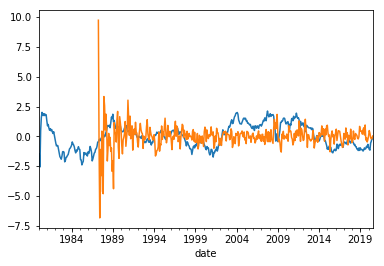

In [402]:
ms_zscore = zscore(agg_ms_change_3mo_ewm)
BondRetIdx_zscore = zscore(BondRetIdx_3mo_ewm_change)

ms_zscore['AUS'].plot()
BondRetIdx_zscore['AUS'].plot()

In [403]:
ms_zscore['AUS'].corr(BondRetIdx_zscore['AUS'], method='pearson')

-0.05088833732888633